In [1]:
import os
import glob

import numpy as np
import pandas as pd

import xarray as xr
import geopandas as gpd
from scipy import stats

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from shapely.geometry import Point, Polygon

import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil')

In [7]:
BR = gpd.read_file(os.path.join('..','..','geometry','BR_UF.geojson')) 

In [8]:
name_in = os.path.join(dir_base,'INM','METADATA.csv')
METADATA = pd.read_csv(name_in)
METADATA.head(4)

,FILE,UF,LAT,LON
0,INMET_CO_DF_A001_BRASILIA_01-01-2023_A_31-12-2...,DF,-15.789444,-47.925833
1,INMET_CO_DF_A042_BRAZLANDIA_01-01-2023_A_31-12...,DF,-15.599722,-48.131111
2,INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2023_A_...,DF,-15.596491,-47.625801
3,INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2023_...,DF,-15.935278,-48.137500


In [9]:
name_in = os.path.join(dir_base,'GSMaP','1ho','GSMaP_Italy_1ho_2023_02_01_2023_02_28.nc')
DATA = xr.open_dataset(name_in)
lats = DATA.lat.values
lons = DATA.lon.values
lon2d, lat2d = np.meshgrid(lons, lats)
time_vec = pd.to_datetime(DATA.time.values)
GSMAP = DATA.PRE.values
print(f'PRE shape: {GSMAP.shape}')

PRE shape: (672, 570, 530)


In [10]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [11]:
BR_count = np.zeros(len(BR))
for geo_n in range(len(BR)):
    count_geo = 0
    for lon, lat in zip(METADATA['LON'], METADATA['LAT']):
        point = Point(lon, lat)
        if BR['geometry'][geo_n].contains(point):
            count_geo = count_geo + 1

    print(f'Province {BR['NM_UF'][geo_n]} has {count_geo} stations')
    BR_count[geo_n] = count_geo

BR_norm = (BR_count)/np.max(BR_count)

Province Rondônia has 4 stations
Province Acre has 7 stations
Province Amazonas has 19 stations
Province Roraima has 1 stations
Province Pará has 33 stations
Province Amapá has 4 stations
Province Tocantins has 20 stations
Province Maranhão has 17 stations
Province Piauí has 21 stations
Province Ceará has 16 stations
Province Rio Grande do Norte has 8 stations
Province Paraíba has 9 stations
Province Pernambuco has 13 stations
Province Alagoas has 7 stations
Province Sergipe has 6 stations
Province Bahia has 44 stations
Province Minas Gerais has 68 stations
Province Espírito Santo has 12 stations
Province Rio de Janeiro has 26 stations
Province São Paulo has 40 stations
Province Paraná has 26 stations
Province Santa Catarina has 24 stations
Province Rio Grande do Sul has 45 stations
Province Mato Grosso do Sul has 27 stations
Province Mato Grosso has 38 stations
Province Goiás has 26 stations
Province Distrito Federal has 5 stations


In [12]:
colors_BR = [(250/255, 128/255, 114/255, alpha) for alpha in sorted(BR_norm)]
cmap_BR = mcolors.ListedColormap(colors_BR)
norm_BR = mcolors.Normalize(vmin=min(BR_count), vmax=max(BR_count))

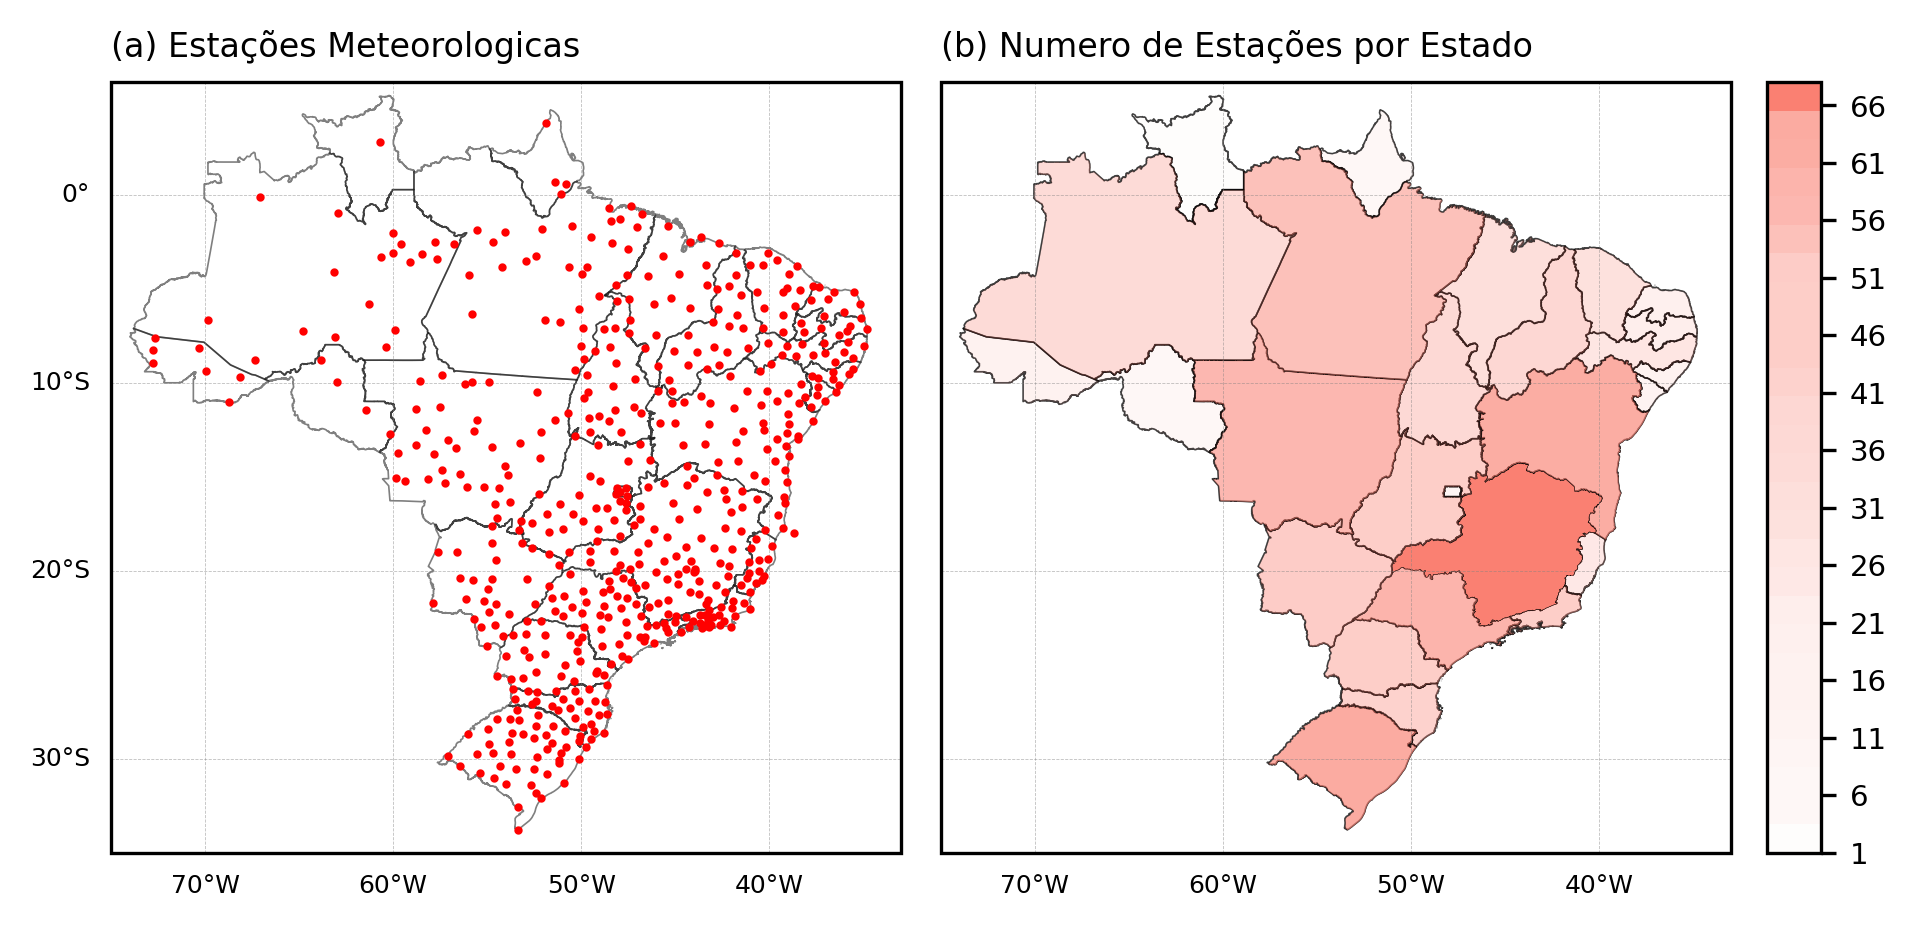

In [13]:
ticks = np.arange(1,68+5,5)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-75, -33, -35, 6],crs=proj)
# ax1.set_extent([-53.110, -44.161, -25.312, -19.779],crs=proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.scatter(METADATA['LON'],METADATA['LAT'],s=1,marker='o',color='r',zorder=10)

ax1.set_title('(a) Estações Meteorologicas',fontsize=8, loc='left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-75, -33, -35, 6],crs=proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
for geo_n in range(len(BR)):
    ax1.add_geometries(BR['geometry'][geo_n], ccrs.PlateCarree(), edgecolor='k', facecolor='salmon', linewidth=0.1, alpha=BR_norm[geo_n])

sm_BR = ScalarMappable(cmap=cmap_BR, norm=norm_BR)
sm_BR.set_array([])
cbaxes = fig.add_axes([0.97, 0.179, 0.03, 0.642]) 
cbar_BR = plt.colorbar(sm_BR, cax=cbaxes, ticks=ticks)
cbar_BR.ax.tick_params(labelsize=7)

ax1.set_title('(b) Numero de Estações por Estado',fontsize=8, loc='left')

#==================================================================================================
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

salida = '../fig/Study_area.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')


In [15]:
# Root-Mean-Square Deviation (RMSD)
def calculate_rmsd(obs, mod):
    differences = obs - mod
    squared_differences = np.square(differences)
    mean_squared_differences = np.nanmean(squared_differences, axis=0)
    rmsd = np.sqrt(mean_squared_differences)
    
    return rmsd

# Mean Bias Error (MBE)
def calculate_mbe(obs, mod):
    return np.nanmean(obs - mod,axis=0)

In [16]:
station_id = 200
CORR = np.zeros(len(METADATA))
RMSD = np.zeros(len(METADATA))
MBE = np.zeros(len(METADATA))

OBS = []
SAT = []

for station_id in range(len(METADATA)):#len(METADATA)

    distances = haversine(lat2d, lon2d, METADATA['LAT'].values[station_id],METADATA['LON'].values[station_id])
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    clat = lats[min_index[0]]
    clon = lons[min_index[1]]

    PRE_GSMAP = GSMAP[:,min_index[0],min_index[1]]

    # print(f"Nearest IMERG lat: {clat}")
    # print(f'Station lat       : {METADATA['LAT'].values[station_id]}')
    # print(f"Nearest IMERG lon: {clon}")
    # print(f'Station lon       : {METADATA['LON'].values[station_id]}')

    PRE_STATION = pd.read_csv(os.path.join(dir_base,'INM','1h',METADATA['FILE'].values[station_id]))
    PRE_STATION['datetime'] = pd.to_datetime(PRE_STATION['datetime'])

    february_data = PRE_STATION[PRE_STATION['datetime'].dt.month == 2]
    february_data.reset_index(drop=True, inplace=True)

    CORR[station_id] = stats.spearmanr(february_data['PRE'].values, PRE_GSMAP).statistic
    RMSD[station_id] = calculate_rmsd(february_data['PRE'].values, PRE_GSMAP)
    MBE[station_id] = calculate_mbe(february_data['PRE'].values, PRE_GSMAP)
    
    OBS.append(february_data['PRE'].values)
    SAT.append(PRE_GSMAP)

OBS = np.concatenate(OBS)
SAT = np.concatenate(SAT)

In [17]:
PRE_STATION

,datetime,PRE
0,2023-01-01 00:00:00+00:00,0.0
1,2023-01-01 01:00:00+00:00,0.0
2,2023-01-01 02:00:00+00:00,0.0
3,2023-01-01 03:00:00+00:00,0.0
4,2023-01-01 04:00:00+00:00,0.0
...,...,...
8755,2023-12-31 19:00:00+00:00,0.0
8756,2023-12-31 20:00:00+00:00,0.0
8757,2023-12-31 21:00:00+00:00,0.0
8758,2023-12-31 22:00:00+00:00,0.0


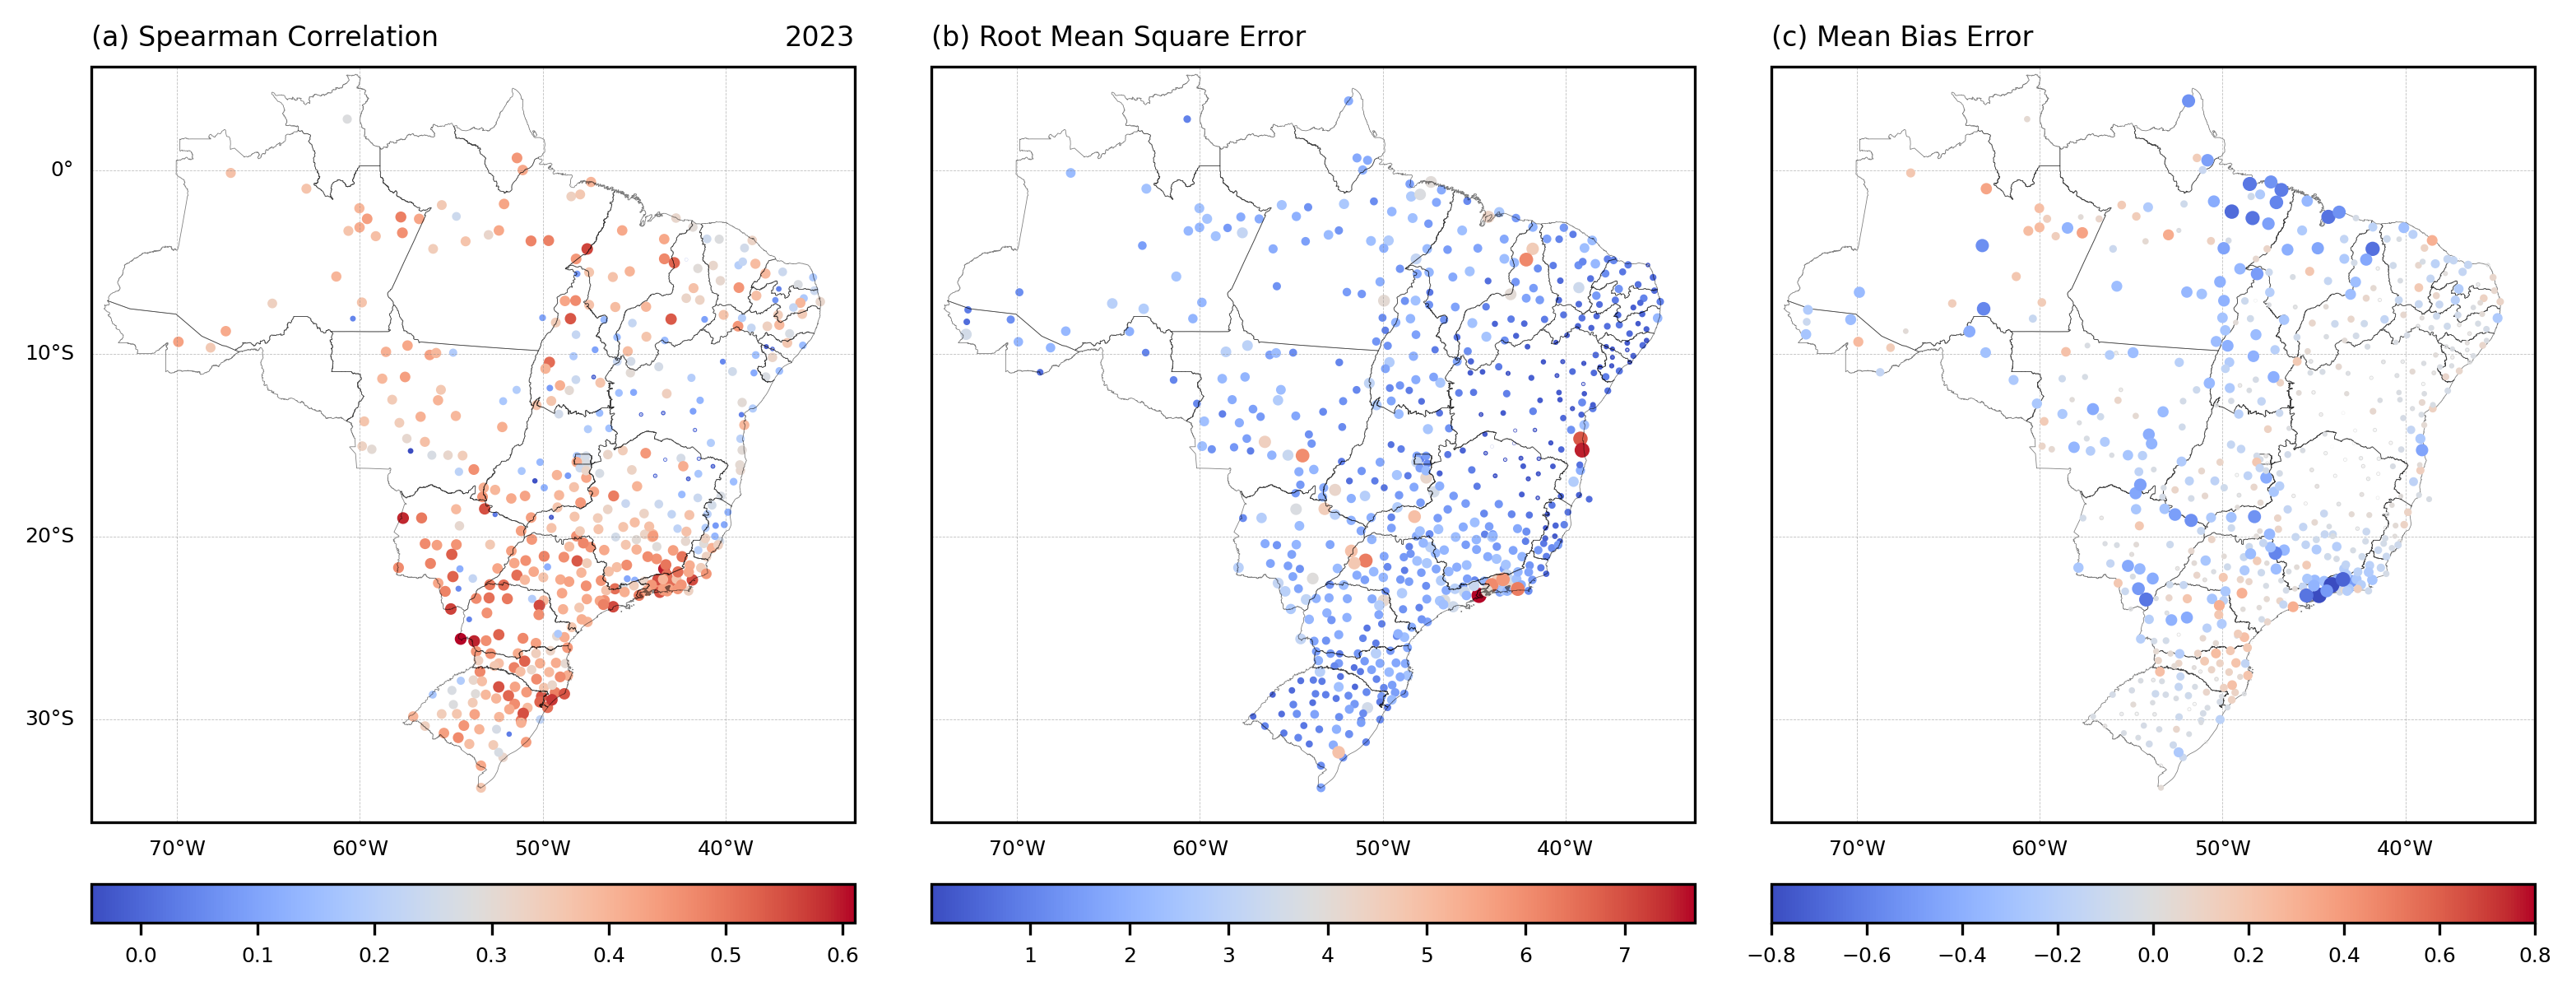

In [36]:
levels = np.arange(-0.8,0.9,0.1)

# cmap = plt.cm.Spectral_r
cmap = plt.cm.coolwarm
norm_MBE = mcolors.Normalize(vmin=-0.8, vmax=0.8)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(11,4),dpi=300)
gs = gridspec.GridSpec(1,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.2, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

a1 = ax1.scatter(METADATA['LON'],METADATA['LAT'], c=CORR, s=abs(CORR)*10, cmap=cmap, alpha=1, edgecolor=None, zorder=1)

cbar = plt.colorbar(a1, fraction=0.05,pad=0.07, orientation='horizontal')
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(a) Spearman Correlation',fontsize=8,loc='left')
ax1.set_title('2023',fontsize=8,loc='right')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.2, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

a1 = ax1.scatter(METADATA['LON'],METADATA['LAT'], c=RMSD, s=abs(RMSD)*1.5, cmap=cmap, alpha=1, edgecolor=None, zorder=1)

cbar = plt.colorbar(a1, fraction=0.05,pad=0.07, orientation='horizontal')
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(b) Root Mean Square Error',fontsize=8,loc='left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.2, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

a1 = ax1.scatter(METADATA['LON'],METADATA['LAT'], c=MBE, s=abs(MBE)*15, cmap=cmap, norm=norm_MBE, alpha=1, edgecolor=None, zorder=10)

cbar = plt.colorbar(a1, fraction=0.05,pad=0.07, orientation='horizontal')
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(c) Mean Bias Error',fontsize=8,loc='left')

#==================================================================================================
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)

salida = '../fig/OBS_GSMAP_Errors.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [47]:
len(MBE[MBE>0]), len(MBE[MBE<0]), len(MBE)

(186, 381, 567)

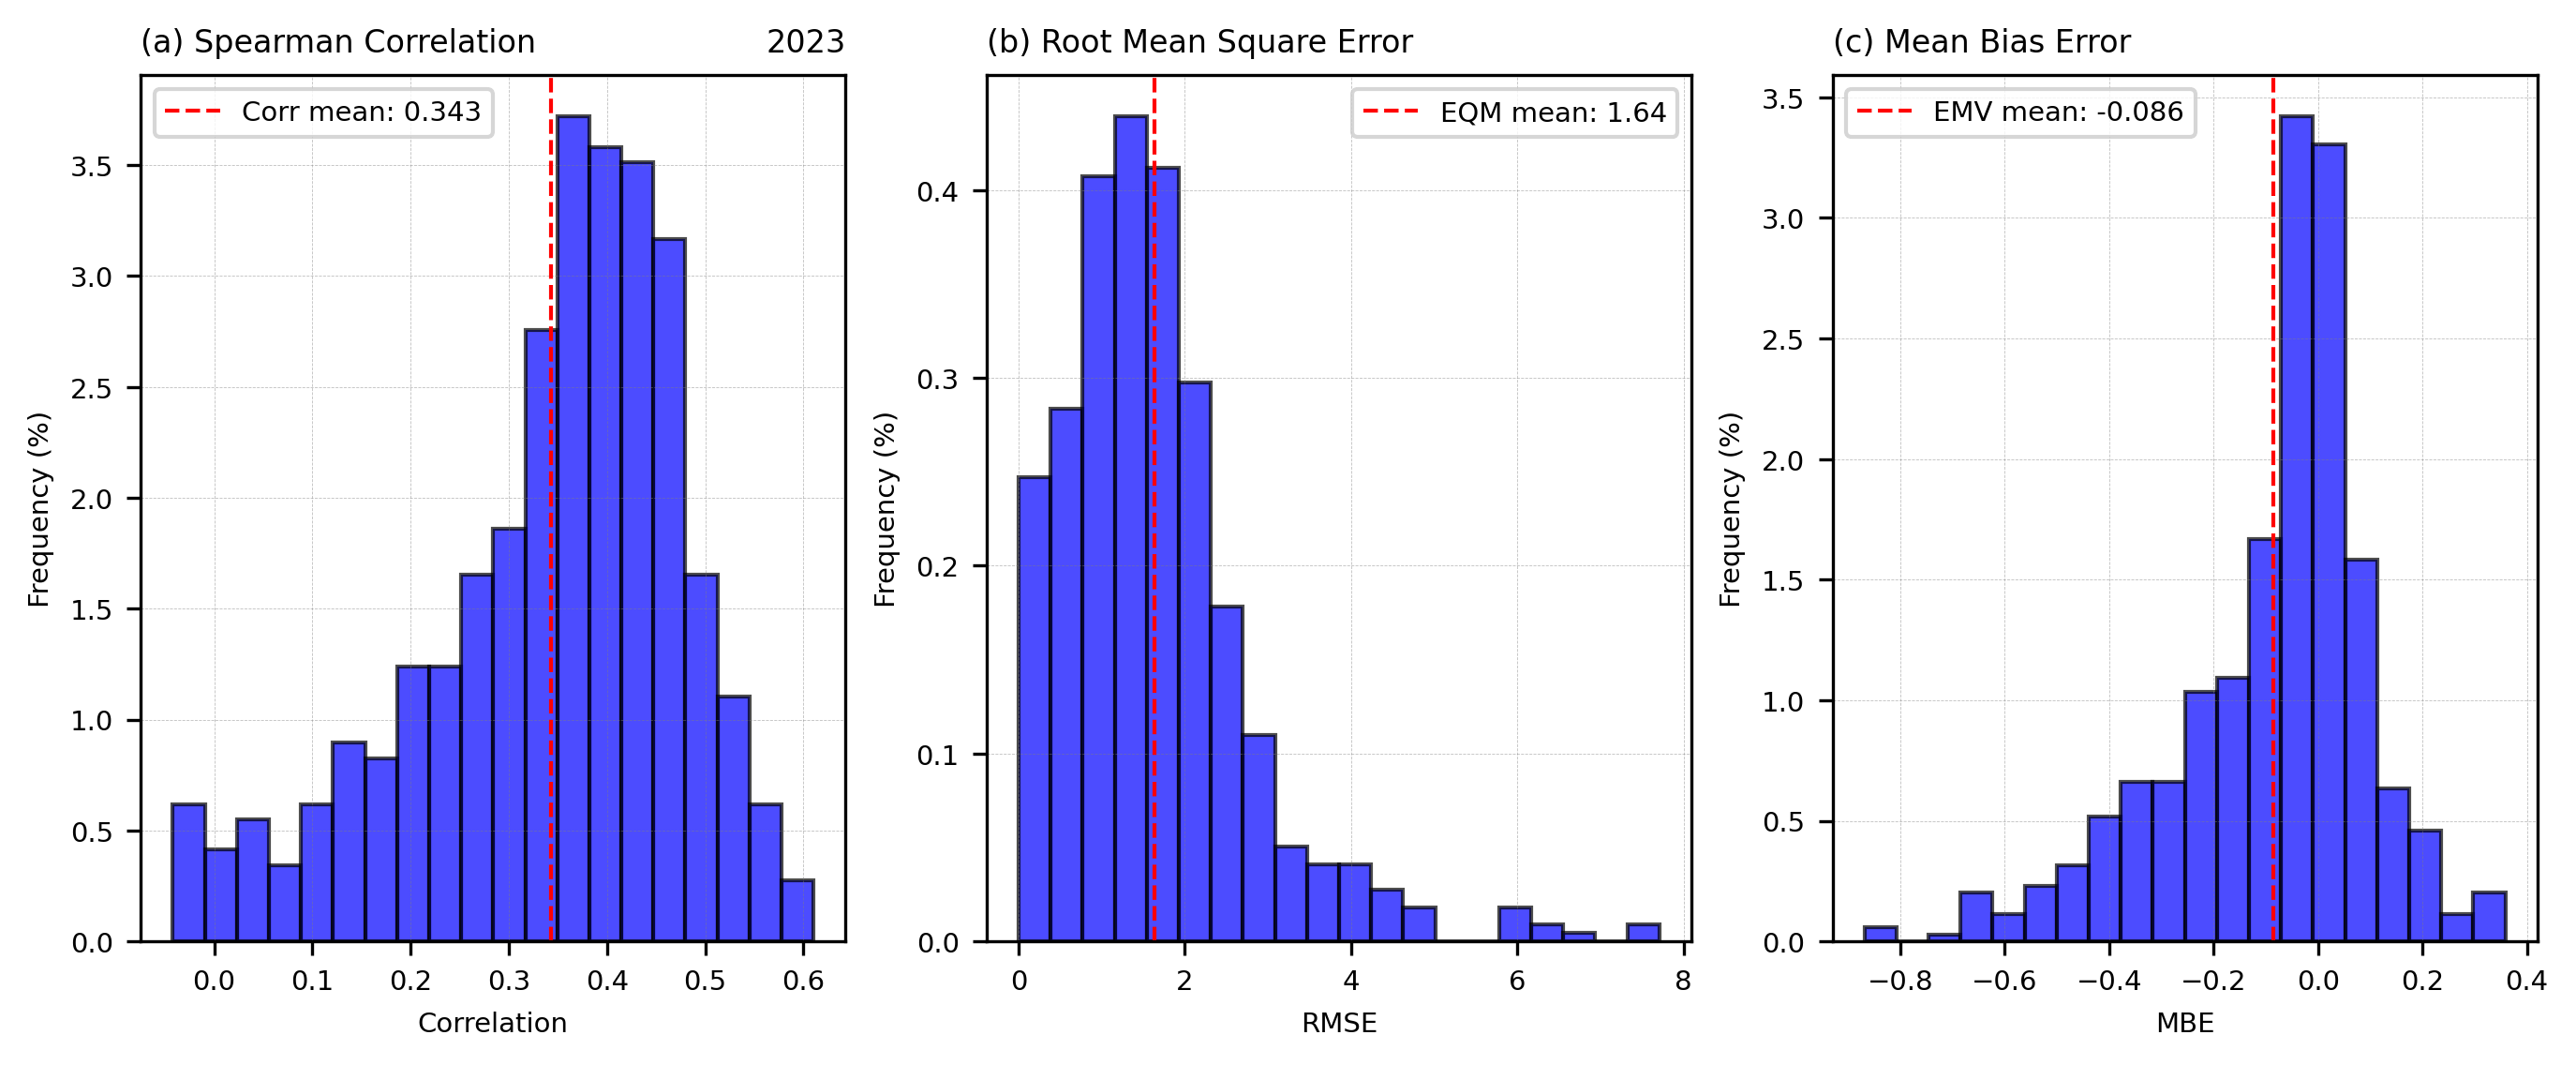

In [48]:
fig = plt.figure(figsize=(11,4),dpi=300)
gs = gridspec.GridSpec(1,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.hist(CORR, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(np.nanmean(CORR), color='r', linestyle='dashed', linewidth=1, label=f'Corr mean: {np.round(np.nanmean(CORR),3)}')

ax1.set_title('(a) Spearman Correlation',fontsize=8,loc='left')
ax1.set_title('2023',fontsize=8,loc='right')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('Frequency (%)',fontsize=7)
ax1.set_xlabel('Correlation',fontsize=7)

ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.legend(fontsize=7,loc='upper left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.hist(RMSD, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(np.nanmean(RMSD), color='r', linestyle='dashed', linewidth=1, label=f'EQM mean: {np.round(np.nanmean(RMSD),3)}')

ax1.set_title('(b) Root Mean Square Error',fontsize=8,loc='left')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('Frequency (%)',fontsize=7)
ax1.set_xlabel('RMSE',fontsize=7)

ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.legend(fontsize=7,loc='upper right')

#==================================================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.hist(MBE, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(np.nanmean(MBE), color='r', linestyle='dashed', linewidth=1, label=f'EMV mean: {np.round(np.nanmean(MBE),3)}')

ax1.set_title('(c) Mean Bias Error',fontsize=8,loc='left')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('Frequency (%)',fontsize=7)
ax1.set_xlabel('MBE',fontsize=7)

ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.legend(fontsize=7,loc='upper left')

salida = '../fig/OBS_GSMAP_barplot.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [49]:
colors_manual = [
        (0.42000000000000004, 0.6333333333333333, 0.8466666666666667, 0.5),
        (0.7400000000000001, 0.31333333333333335, 0.7400000000000001, 0.5),
        (0.5800000000000001, 0.9, 0.3666666666666667, 0.5)]

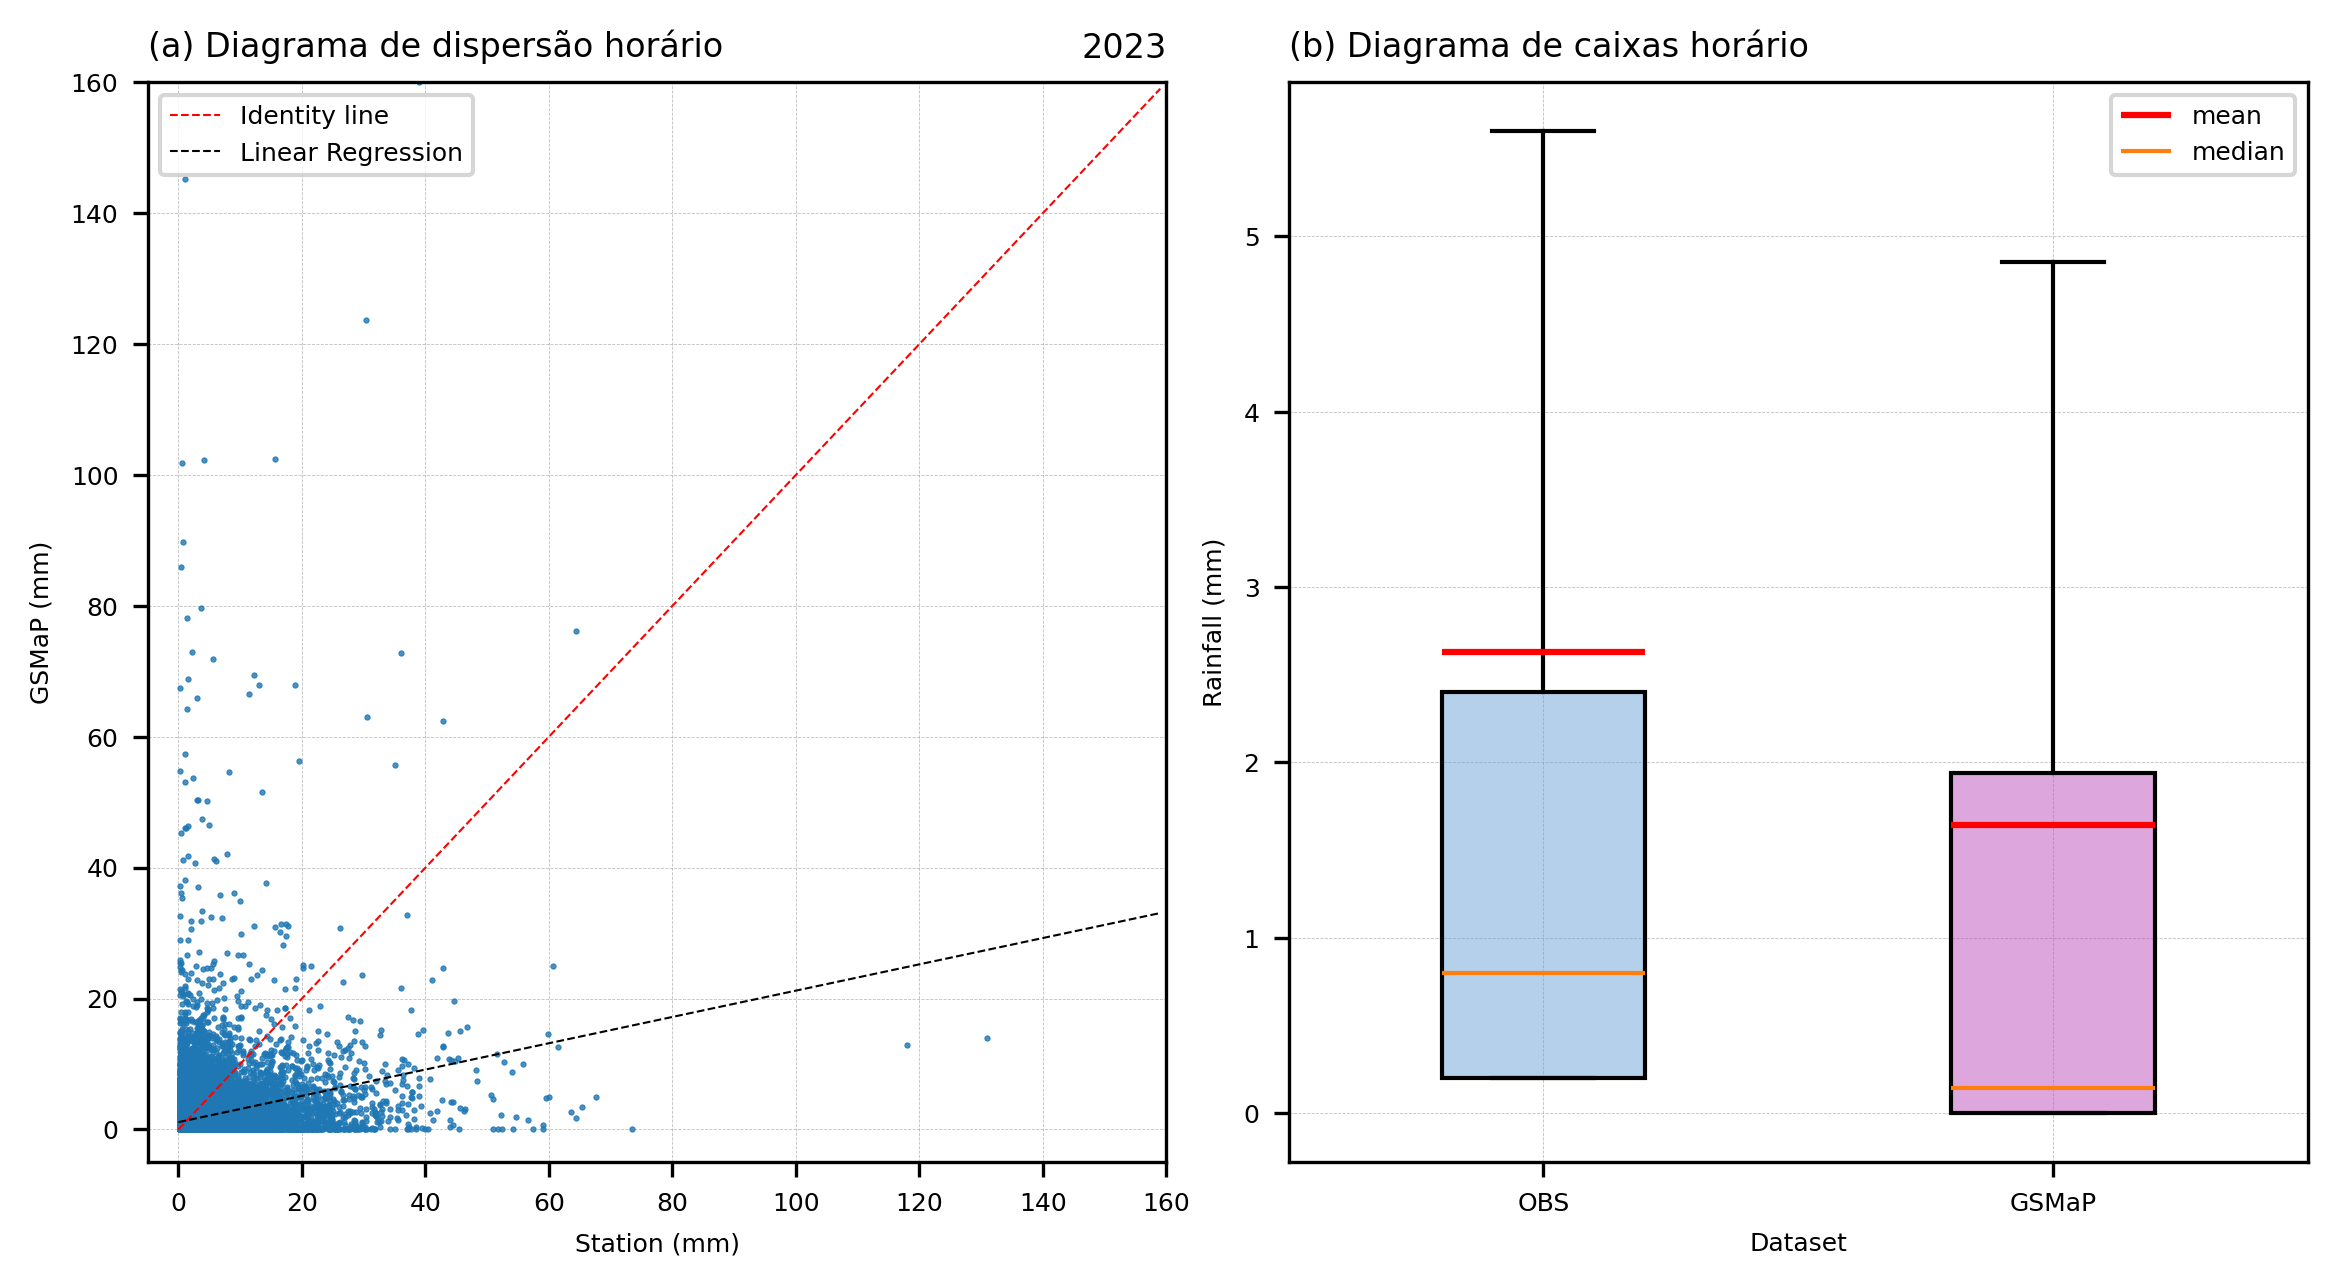

In [50]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(OBS[OBS>0], SAT[OBS>0], '.',markersize=1, alpha=0.9)

x = np.arange(0,160,1)
ax1.plot(x,x,'r--',linewidth=0.5, label='Identity line')

slope, intercept, r_value, p_value, std_err = stats.linregress(OBS[OBS>0], SAT[OBS>0])
ax1.plot(x, slope*x + intercept, 'k--',linewidth=0.5, label='Linear Regression')

ax1.set_xlim(-5,160)
ax1.set_ylim(-5,160)
ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('(a) Diagrama de dispersão horário',fontsize=8,loc='left')
ax1.set_title('2023',fontsize=8,loc='right')
ax1.set_xlabel('Station (mm)',fontsize=6)
ax1.set_ylabel('GSMaP (mm)',fontsize=6)
ax1.legend(fontsize=6,loc='upper left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])

boxes = []
medians = []
mean = []

for n in range(2):
    if n == 0:
        box = ax1.boxplot(OBS[OBS>0],positions=[n],
        widths=0.4,boxprops=dict(facecolor=colors_manual[n]),
        showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
        showfliers=False,flierprops=dict(marker='_',color='k',linewidth=1.5),
        patch_artist=True,notch=False)
    else:
        box = ax1.boxplot(SAT[OBS>0],positions=[n],
        widths=0.4,boxprops=dict(facecolor=colors_manual[n]),
        showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
        showfliers=False,flierprops=dict(marker='_',color='k',linewidth=1.5),
        patch_artist=True,notch=False)

    boxes.append(box["boxes"][0])
    medians.append(box["medians"][0])
    mean.append(box["means"][0])

ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('(b) Diagrama de caixas horário',fontsize=8,loc='left')
ax1.set_ylabel('Rainfall (mm)',fontsize=6)
ax1.set_xlabel('Dataset',fontsize=6)

ax1.legend([mean[0], medians[0]],
        ['mean', 'median'], 
        ncol=1,fontsize=6,loc=1)

ax1.set_xticks([0,1])
ax1.set_xticklabels(['OBS','GSMaP'],fontsize=6)

#==================================================================================================
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.12, hspace=0.1)

salida = '../fig/OBS_GSMAP_Scatter_boxplot.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Extreme event 19 Feb 2023

In [42]:
EXTREME = METADATA[(METADATA['LON']>-46.5)&(METADATA['LON']<-45)&(METADATA['LAT']>-25)&(METADATA['LAT']<-22)]
EXTREME

,FILE,UF,LAT,LON
343,INMET_SE_MG_A509_MONTE VERDE_01-01-2023_A_31-1...,MG,-22.861667,-46.043333
365,INMET_SE_MG_A531_MARIA DA FE_01-01-2023_A_31-1...,MG,-22.314444,-45.373056
434,INMET_SE_SP_A706_CAMPOS DO JORDAO_01-01-2023_A...,SP,-22.750278,-45.603889
447,INMET_SE_SP_A728_TAUBATE_01-01-2023_A_31-12-20...,SP,-23.041667,-45.520833
455,INMET_SE_SP_A740_SAO LUIZ DO PARAITINGA_01-01-...,SP,-23.228333,-45.416944
466,INMET_SE_SP_A765_BERTIOGA_01-01-2023_A_31-12-2...,SP,-23.844722,-46.143333
469,INMET_SE_SP_A769_CACHOEIRA PAULISTA_01-01-2023...,SP,-22.688889,-45.005556


In [43]:
EXTREME = EXTREME[EXTREME['FILE']=='INMET_SE_SP_A765_BERTIOGA_01-01-2023_A_31-12-2023.CSV']

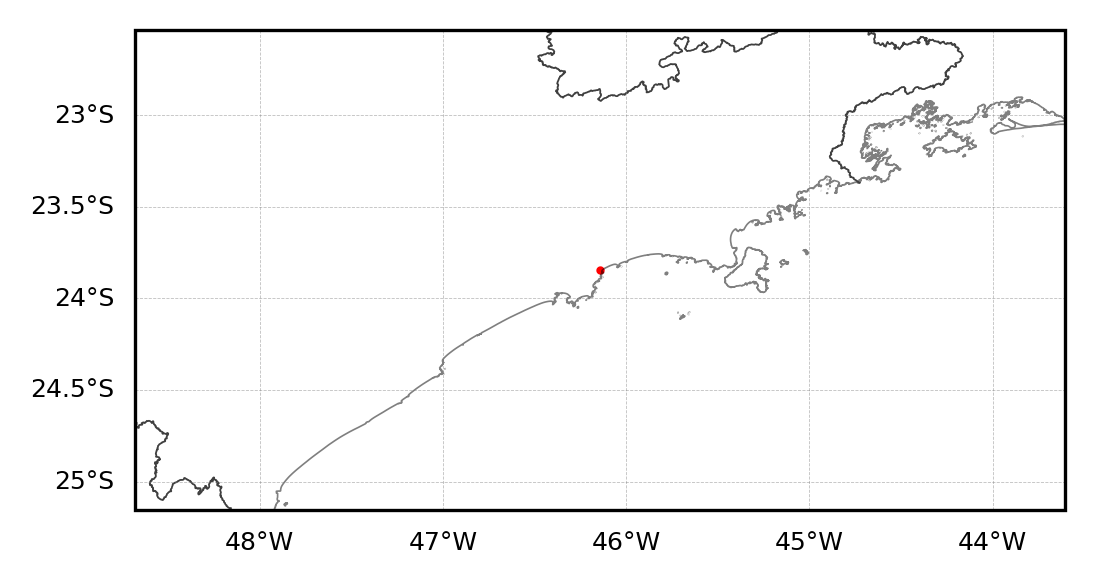

In [44]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-53.110, -44.161, -25.312, -19.779],crs=proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.scatter(EXTREME['LON'],EXTREME['LAT'],s=1,marker='o',color='r',transform=proj)

In [45]:
# TMP = pd.read_csv(os.path.join(dir_base,'INM','1h','INMET_SE_SP_A765_BERTIOGA_01-01-2023_A_31-12-2023.CSV'))
# TMP['datetime'] = pd.to_datetime(TMP['datetime'])
# TMP_data = TMP[TMP['datetime'].dt.month == 2]
# TMP_data.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(10, 6))
# plt.plot(time_vec, np.cumsum(TMP_data['PRE'].values), label='OBS', color='blue')
# # plt.plot(time_vec, np.cumsum(PRE_GSMAP), label='GSMaP', color='orange', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Accumulated Precipitation')
# plt.title('Accumulated Precipitation: OBS vs GSMaP')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

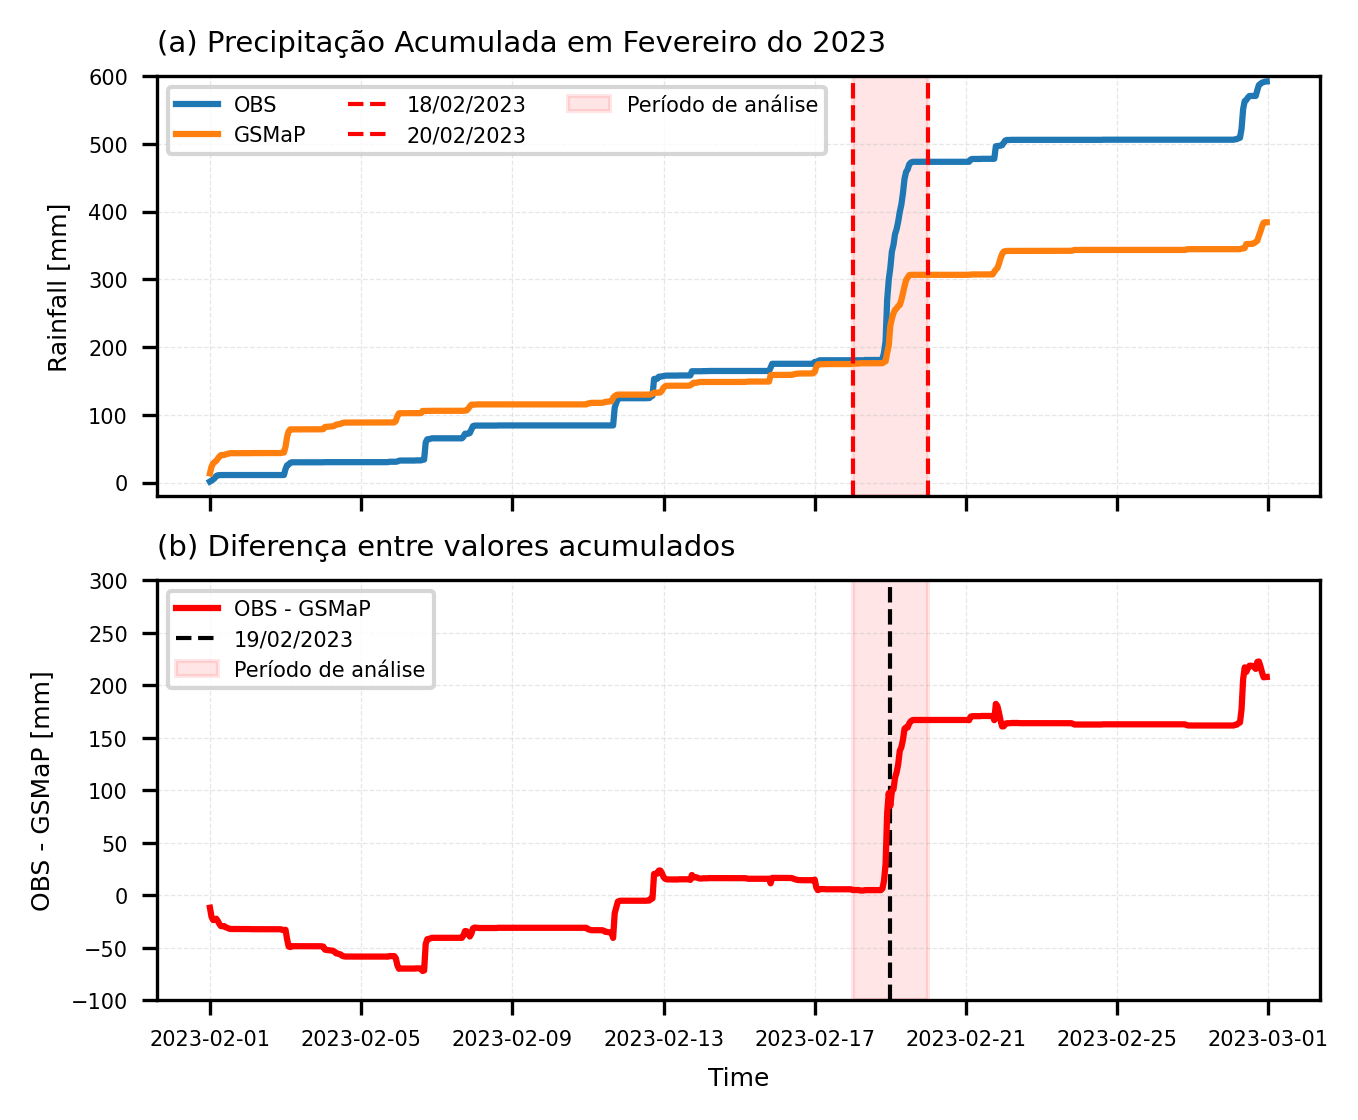

In [68]:
fig = plt.figure(figsize=(5,4),dpi=300)
gs = gridspec.GridSpec(2,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
for station_id in range(len(EXTREME)):

    distances = haversine(lat2d, lon2d, EXTREME['LAT'].values[station_id],EXTREME['LON'].values[station_id])
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    clat = lats[min_index[0]]
    clon = lons[min_index[1]]

    EXT_GSMAP = GSMAP[:,min_index[0],min_index[1]]

    PRE_STATION = pd.read_csv(os.path.join(dir_base,'INM','1h',EXTREME['FILE'].values[station_id]))
    PRE_STATION['datetime'] = pd.to_datetime(PRE_STATION['datetime'])

    EXT_OBS = PRE_STATION[PRE_STATION['datetime'].dt.month == 2]
    EXT_OBS.reset_index(drop=True, inplace=True)

    ax1.plot(time_vec, np.cumsum(EXT_OBS['PRE'].values), label='OBS')
    ax1.plot(time_vec, np.cumsum(EXT_GSMAP), label='GSMaP')

# add two vertical line for the extreme event
ax1.axvline(pd.to_datetime('2023-02-18 00:00:00'), color='r', linestyle='--', linewidth=1, label='18/02/2023')
ax1.axvline(pd.to_datetime('2023-02-20 00:00:00'), color='r', linestyle='--', linewidth=1, label='20/02/2023')

#fill the area between the two vertical lines
ax1.fill_between([pd.to_datetime('2023-02-18 00:00:00'), pd.to_datetime('2023-02-20 00:00:00')], -20, 650, color='red', alpha=0.1, label='Período de análise')

ax1.set_title('(a) Precipitação Acumulada em Fevereiro do 2023', fontsize=7, loc='left')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_ylim(-20,600)

ax1.set_xticklabels([])
ax1.set_ylabel('Rainfall [mm]', fontsize=6)

ax1.legend(fontsize=5, ncols=3)
ax1.grid(alpha=0.3, linewidth=0.3, linestyle='--')

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(time_vec, np.cumsum(EXT_OBS['PRE'].values)- np.cumsum(EXT_GSMAP), c='r', label='OBS - GSMaP',zorder=10)

# add two vertical line for the extreme event
ax1.axvline(pd.to_datetime('2023-02-19 00:00:00'), color='k', linestyle='--', linewidth=1, label='19/02/2023')
# ax1.axvline(pd.to_datetime('2023-02-20 00:00:00'), color='r', linestyle='--', linewidth=1, label='20/02/2023')

#fill the area between the two vertical lines
ax1.fill_between([pd.to_datetime('2023-02-18 00:00:00'), pd.to_datetime('2023-02-20 00:00:00')], -100, 650, color='red', alpha=0.1, label='Período de análise')

ax1.set_title('(b) Diferença entre valores acumulados', fontsize=7, loc='left')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_ylim(-100,300)

ax1.legend(fontsize=5, ncols=1)
ax1.grid(alpha=0.3, linewidth=0.3, linestyle='--')

ax1.set_xlabel('Time', fontsize=6)
ax1.set_ylabel('OBS - GSMaP [mm]', fontsize=6)

#==================================================================================================
salida = '../fig/Sao_Sebastiao_OBS_GSMAP.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [69]:
res = stats.spearmanr(np.cumsum(EXT_OBS['PRE'].values), np.cumsum(EXT_GSMAP))
res.statistic

np.float64(0.9967619523074914)

In [21]:
EVENT = DATA.sel(time=slice("2023-02-18", "2023-02-20"))

lon_max, lon_min, lat_max, lat_min = -53.110, -44.161, -25.312, -19.779
EVENT = EVENT.sel(lon=slice(lon_max-1, lon_min+1),lat=slice(lat_max-1, lat_min+1))

lon2d, lat2d = np.meshgrid(EVENT['lon'].values, EVENT['lat'].values)

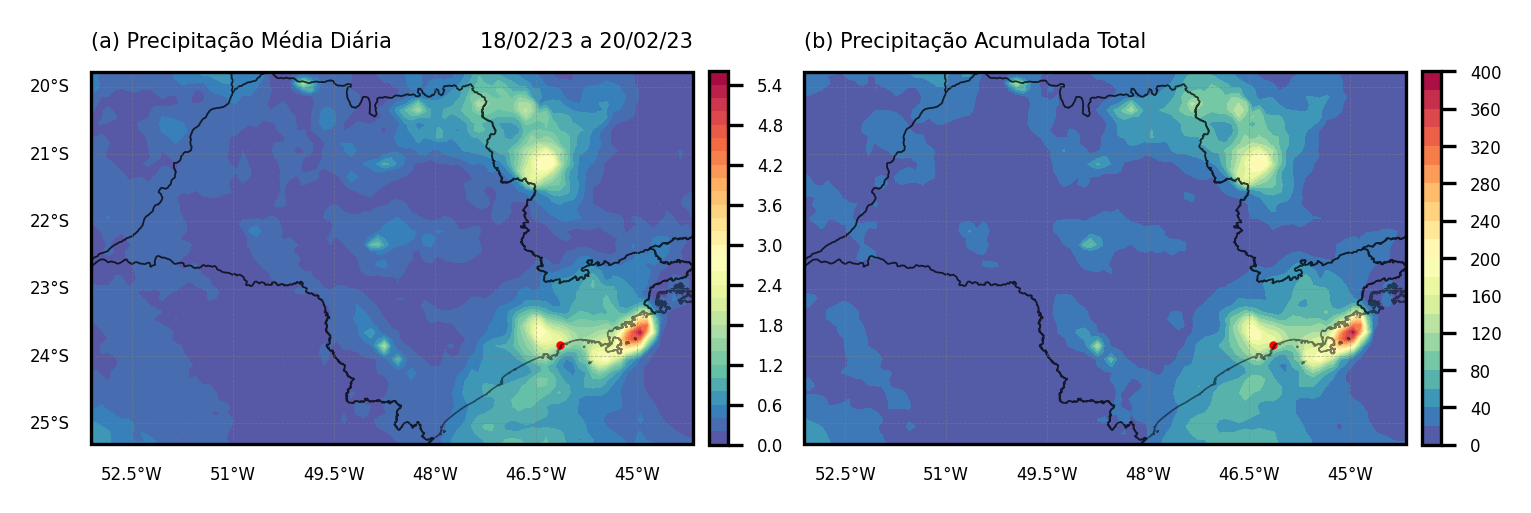

In [22]:
cmap = plt.cm.Spectral_r

levels_mean = np.arange(0,5.8,0.2)
ticks_mean = np.arange(0,5.2+0.6,0.6)

levels_sum = np.arange(0,420, 20)
ticks_sum = np.arange(0,440, 40)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(5,4),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_max, lon_min, lat_max, lat_min],crs=proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(EVENT['PRE'].values,axis=0), cmap=cmap, levels=levels_mean)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, ticks=ticks_mean, fraction=0.0293, pad=0.025)
cbar.ax.tick_params(labelsize=4)

ax1.scatter(EXTREME['LON'],EXTREME['LAT'],s=1,marker='o',color='r',transform=proj)

ax1.set_title('(a) Precipitação Média Diária', fontsize=5, loc='left')
ax1.set_title('18/02/23 a 20/02/23', fontsize=5, loc='right')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_max, lon_min, lat_max, lat_min],crs=proj)
ax1.add_geometries(BR.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

a1 = ax1.contourf(lon2d, lat2d, np.sum(EVENT['PRE'].values,axis=0), cmap=cmap, levels=levels_sum)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, ticks=ticks_sum, fraction=0.0293, pad=0.025)
cbar.ax.tick_params(labelsize=4)

ax1.scatter(EXTREME['LON'],EXTREME['LAT'],s=1,marker='o',color='r',transform=proj)

ax1.set_title('(b) Precipitação Acumulada Total', fontsize=5, loc='left')

#==================================================================================================
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.12, hspace=0.1)

salida = '../fig/Sao_Sebastiao_19_02_2023.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [23]:
EXT_OBS['date'] = EXT_OBS['datetime'].dt.date
start_date = pd.to_datetime('2023-02-18').date()
end_date = pd.to_datetime('2023-02-20').date()
filtered_df = EXT_OBS[(EXT_OBS['date'] >= start_date) & (EXT_OBS['date'] <= end_date)]

In [24]:
distances = haversine(lat2d, lon2d, EXTREME['LAT'].values[station_id],EXTREME['LON'].values[station_id])
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
EVENT_GSMAP_serie = EVENT['PRE'].values[:,min_index[0],min_index[1]]

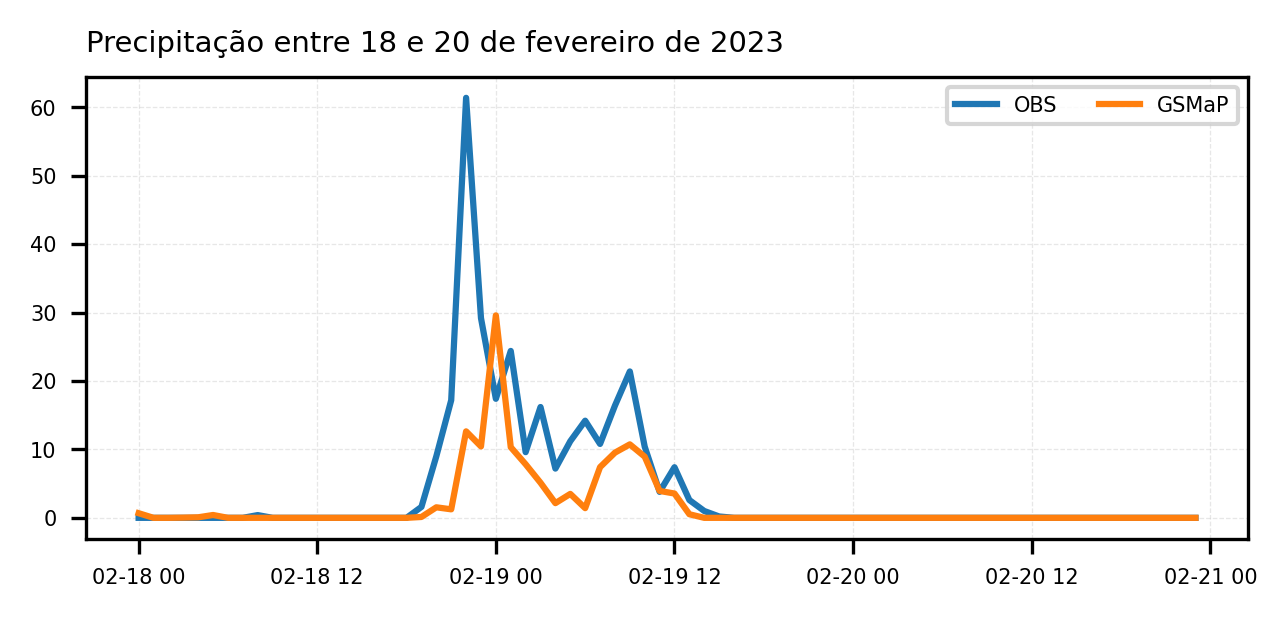

In [25]:
fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(filtered_df['datetime'], filtered_df['PRE'], label='OBS')
ax1.plot(filtered_df['datetime'],EVENT_GSMAP_serie, label='GSMaP')

ax1.grid(alpha=0.3, linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)

ax1.legend(fontsize=5, ncols=3)
ax1.set_title('Precipitação entre 18 e 20 de fevereiro de 2023', fontsize=7, loc='left')

#==================================================================================================
salida = '../fig/Sao_Sebastiao_series.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [70]:
res = stats.spearmanr(filtered_df['PRE'], EVENT_GSMAP_serie)
res.statistic

np.float64(0.8715541635407303)

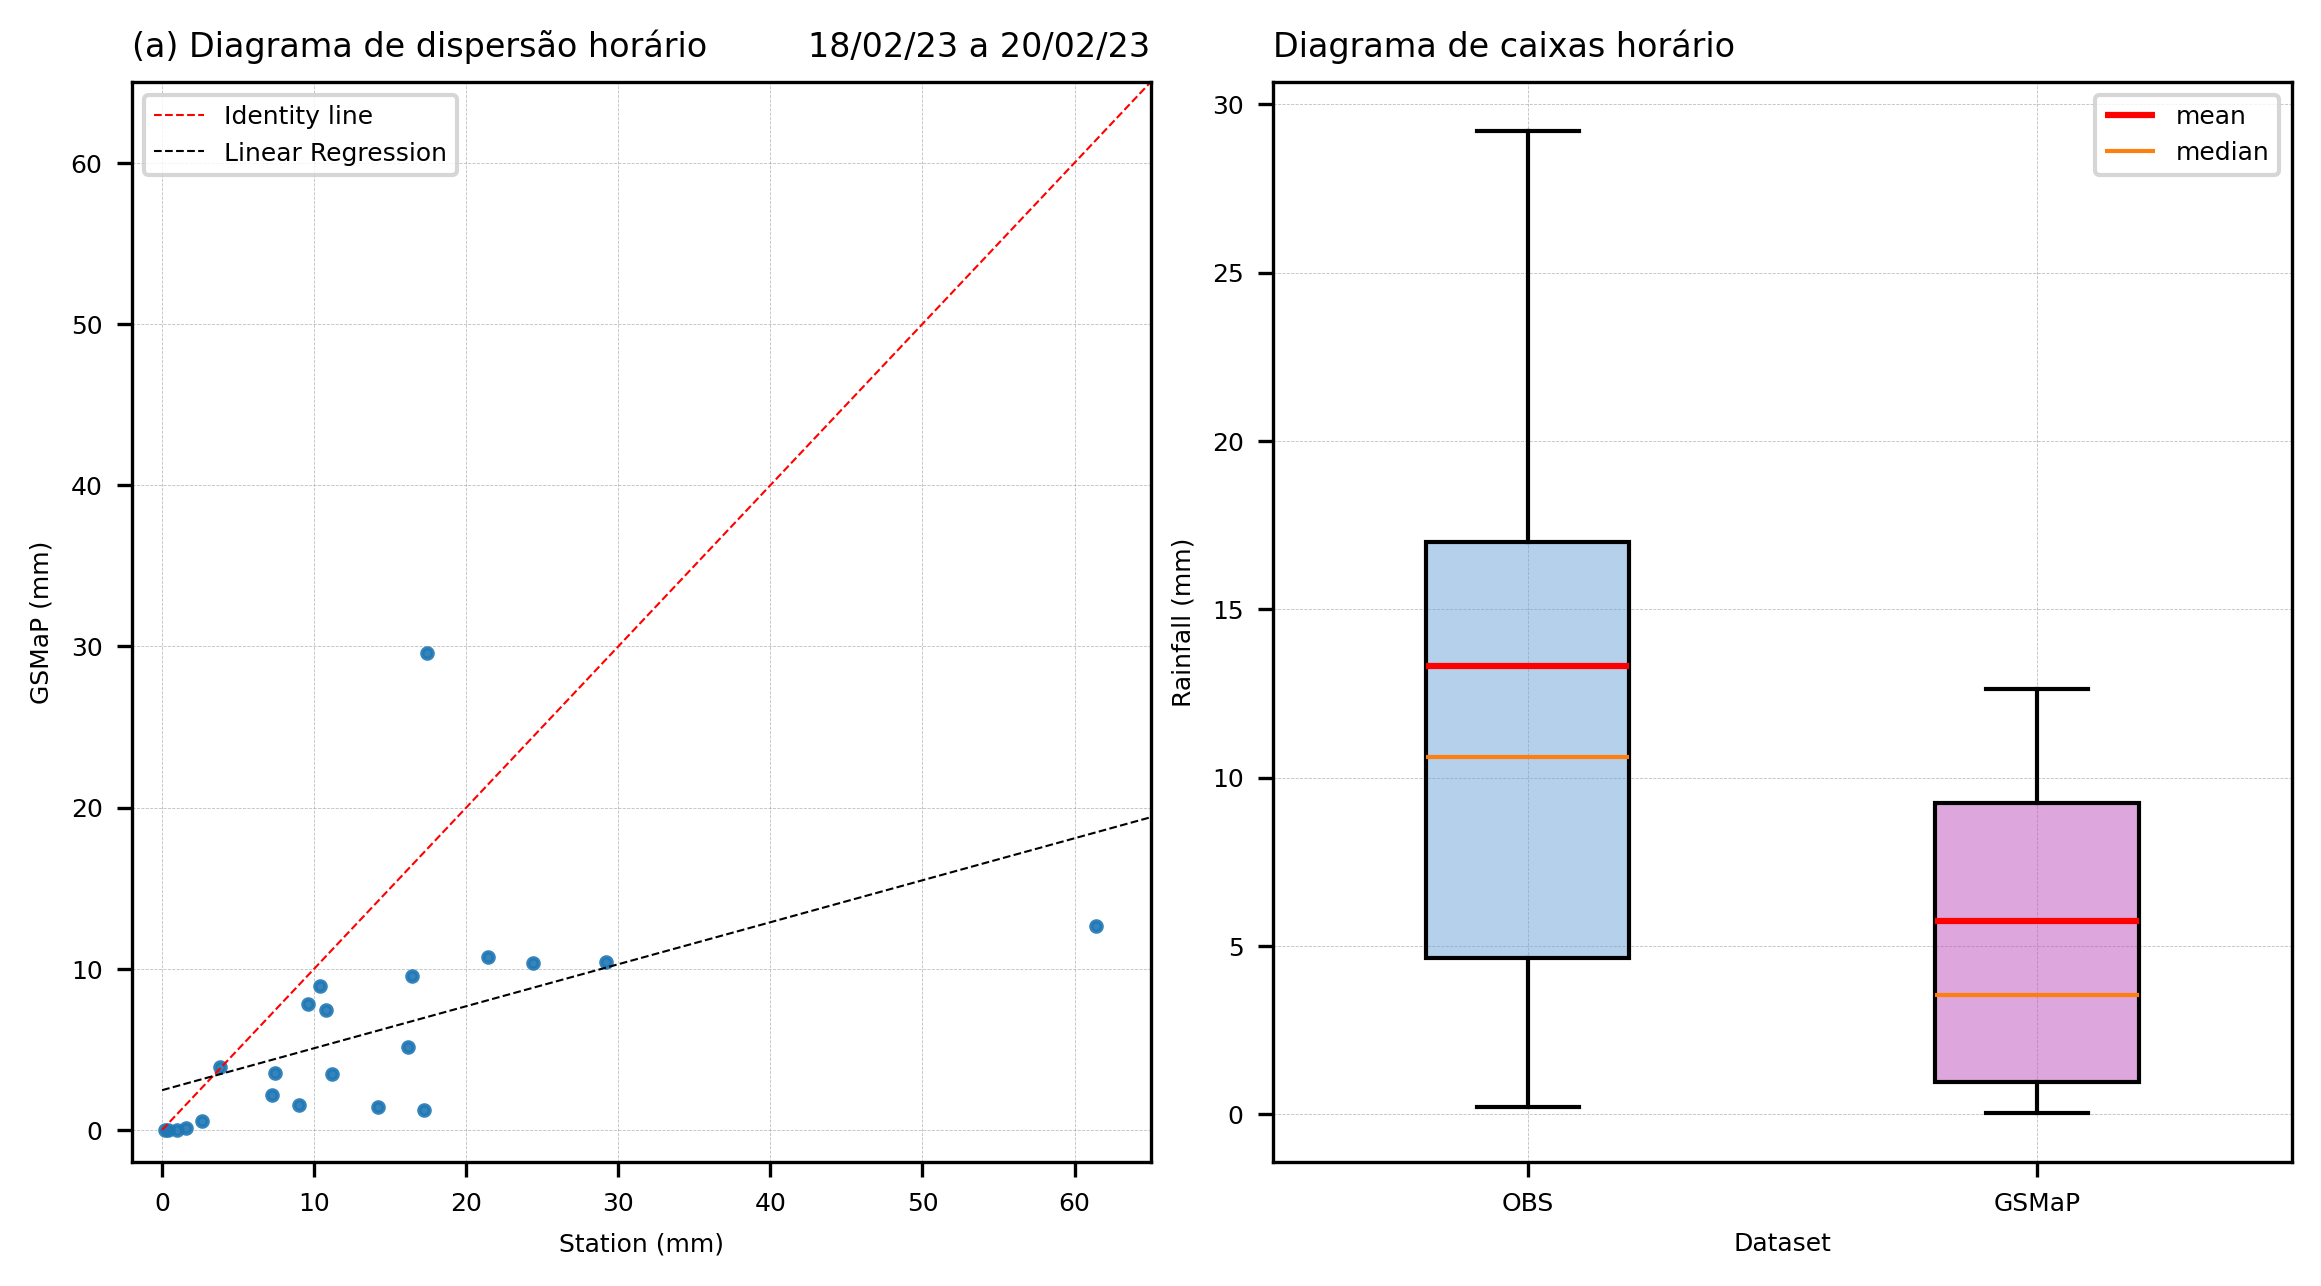

In [26]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(1,2)

OBS_event = filtered_df['PRE'].values
GSMaP_event = EVENT_GSMAP_serie

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(OBS_event[OBS_event>0], GSMaP_event[OBS_event>0], '.',markersize=5, alpha=0.9)

x = np.arange(0,len(OBS_event),1)
ax1.plot(x,x,'r--',linewidth=0.5, label='Identity line')

slope, intercept, r_value, p_value, std_err = stats.linregress(OBS_event[OBS_event>0], GSMaP_event[OBS_event>0])
ax1.plot(x, slope*x + intercept, 'k--',linewidth=0.5, label='Linear Regression')

ax1.set_xlim(-2,65)
ax1.set_ylim(-2,65)
ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('(a) Diagrama de dispersão horário',fontsize=8,loc='left')
ax1.set_title('18/02/23 a 20/02/23',fontsize=8,loc='right')
ax1.set_xlabel('Station (mm)',fontsize=6)
ax1.set_ylabel('GSMaP (mm)',fontsize=6)
ax1.legend(fontsize=6,loc='upper left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])

boxes = []
medians = []
mean = []

for n in range(2):
    if n == 0:
        box = ax1.boxplot(OBS_event[OBS_event>0],positions=[n],
        widths=0.4,boxprops=dict(facecolor=colors_manual[n]),
        showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
        showfliers=False,flierprops=dict(marker='_',color='k',linewidth=1.5),
        patch_artist=True,notch=False)
    else:
        box = ax1.boxplot(GSMaP_event[GSMaP_event>0],positions=[n],
        widths=0.4,boxprops=dict(facecolor=colors_manual[n]),
        showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
        showfliers=False,flierprops=dict(marker='_',color='k',linewidth=1.5),
        patch_artist=True,notch=False)

    boxes.append(box["boxes"][0])
    medians.append(box["medians"][0])
    mean.append(box["means"][0])

ax1.grid(linewidth=0.2, linestyle='--', color='gray', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)

ax1.set_title('Diagrama de caixas horário',fontsize=8,loc='left')

ax1.set_ylabel('Rainfall (mm)',fontsize=6)
ax1.set_xlabel('Dataset',fontsize=6)

ax1.legend([mean[0], medians[0]],
        ['mean', 'median'], 
        ncol=1,fontsize=6,loc=1)

ax1.set_xticks([0,1])
ax1.set_xticklabels(['OBS','GSMaP'],fontsize=6)

#==================================================================================================
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.12, hspace=0.1)

salida = '../fig/Sao_Sebastiao_compare.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')